# Analisis dan Model Prediksi Terhadap Dataset Pengklasifikasian Nasabah dengan Resiko Kredit yang Baik dan Buruk

Open Recruitment Anggota Labortarium Sistem Cerdas
By: Muhammad Yasin Hakim

Dalam dataset ini, terdapat beberapa atribut-atribut dari nasabah yang dapat mendeskripsikan mengenai resiko kredit nasabah tersebut apakah baik(good) atau buruk(bad). Dengan menganalisis dataset ini, kita dapat menarik beberapa wawasan mengenai hubungan antara atribut-atribut tersebut dengan klasifikasi resiko kreditnya. Selain itu, hasil analisis tersebut juga dapat membantu model pembelajaran untuk melakukan prediksi klasifikasi pada data-data lainnya dengan lebih akurat.

Satu catatan penting, penekanan pada model prediksi nantinya adalah untuk meminimalisir pengklasifikasian seorang nasabah sebagai pemilik kredit baik padahal seharusnya ia adalah pemilik kredit buruk **(false positive)** dibandingkan pengklasifikasian seorang nasabah sebagai pemilik kredit buruk padahal seharusnya ia adalah pemilik kredit baik **(false negative)**.

# Importing Libraries

In [339]:
import pandas as pd
import numpy as np
import math
import re
import requests
import warnings
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel


# Data Extraction

In [340]:
# Make the request to download the file
destination = 'dataset'
url = "https://drive.google.com/uc?export=download&id=18iU8RdN-5TtLm5rHEk2fpbNtl4VxxtLH"
response = requests.get(url)

# Save the content to a file
with open(destination, 'wb') as file:
    file.write(response.content)

print(f"Downloaded {destination}")

Downloaded dataset


In [341]:
data = arff.loadarff("dataset")
df = pd.DataFrame(data[0])
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [295]:
#Membersihkan prefix dan suffix yang ada di dataset
def clean_value(value):
    value = str(value)
    value = re.sub(r"^b'|'$", "", value)
    
    try:
        return float(value)
    except ValueError:
        return value

df = df.applymap(clean_value)
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


# EDA

Tahap ini dilakukan untuk mengeksplorasi dan menganalisis dataset yang dipakai untuk mendapatkan insight-insight yang berguna untuk tahap data preprocessing dan modelling

## Checking Data Information

In [296]:
print(df.shape)

(1000, 21)


In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [298]:
df.duplicated().sum()

0

In [299]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [300]:
#Unique values per column
cols = df.columns

for col in cols:
    print(f"{col} -> nunique: {df[col].nunique()} \n -> unique val: {df[col].unique()} \n ----------------- \n")

checking_status -> nunique: 4 
 -> unique val: ['<0' '0<=X<200' 'no checking' '>=200'] 
 ----------------- 

duration -> nunique: 33 
 -> unique val: [ 6. 48. 12. 42. 24. 36. 30. 15.  9. 10.  7. 60. 18. 45. 11. 27.  8. 54.
 20. 14. 33. 21. 16.  4. 47. 13. 22. 39. 28.  5. 26. 72. 40.] 
 ----------------- 

credit_history -> nunique: 5 
 -> unique val: ['critical/other existing credit' 'existing paid' 'delayed previously'
 'no credits/all paid' 'all paid'] 
 ----------------- 

purpose -> nunique: 10 
 -> unique val: ['radio/tv' 'education' 'furniture/equipment' 'new car' 'used car'
 'business' 'domestic appliance' 'repairs' 'other' 'retraining'] 
 ----------------- 

credit_amount -> nunique: 921 
 -> unique val: [ 1169.  5951.  2096.  7882.  4870.  9055.  2835.  6948.  3059.  5234.
  1295.  4308.  1567.  1199.  1403.  1282.  2424.  8072. 12579.  3430.
  2134.  2647.  2241.  1804.  2069.  1374.   426.   409.  2415.  6836.
  1913.  4020.  5866.  1264.  1474.  4746.  6110.  2100.  1225.  

### Target - class

In [301]:
value_count = df["class"].value_counts()
value_count

class
good    700
bad     300
Name: count, dtype: int64

Dari pengecekan informasi data di atas, didapatkan bahwa:
1. Terdapat 1000 baris dan 21 kolom data
2. Terdapat 1 kolom target ('class') yang merupakan kelas yang diprediksi
3. Dataset terdiri dari 2 kelas: 'good'(dengan jumlah 700 baris) dan 'bad' (dengan jumlah 300 baris)
4. Tidak ada data yang terduplikasi dan yang memiliki nilai NULL
5. Ada kemungkinan adanya outlier, terkhusus pada kolom credit_amount

## Univariate Analysis

### Numerical Columns

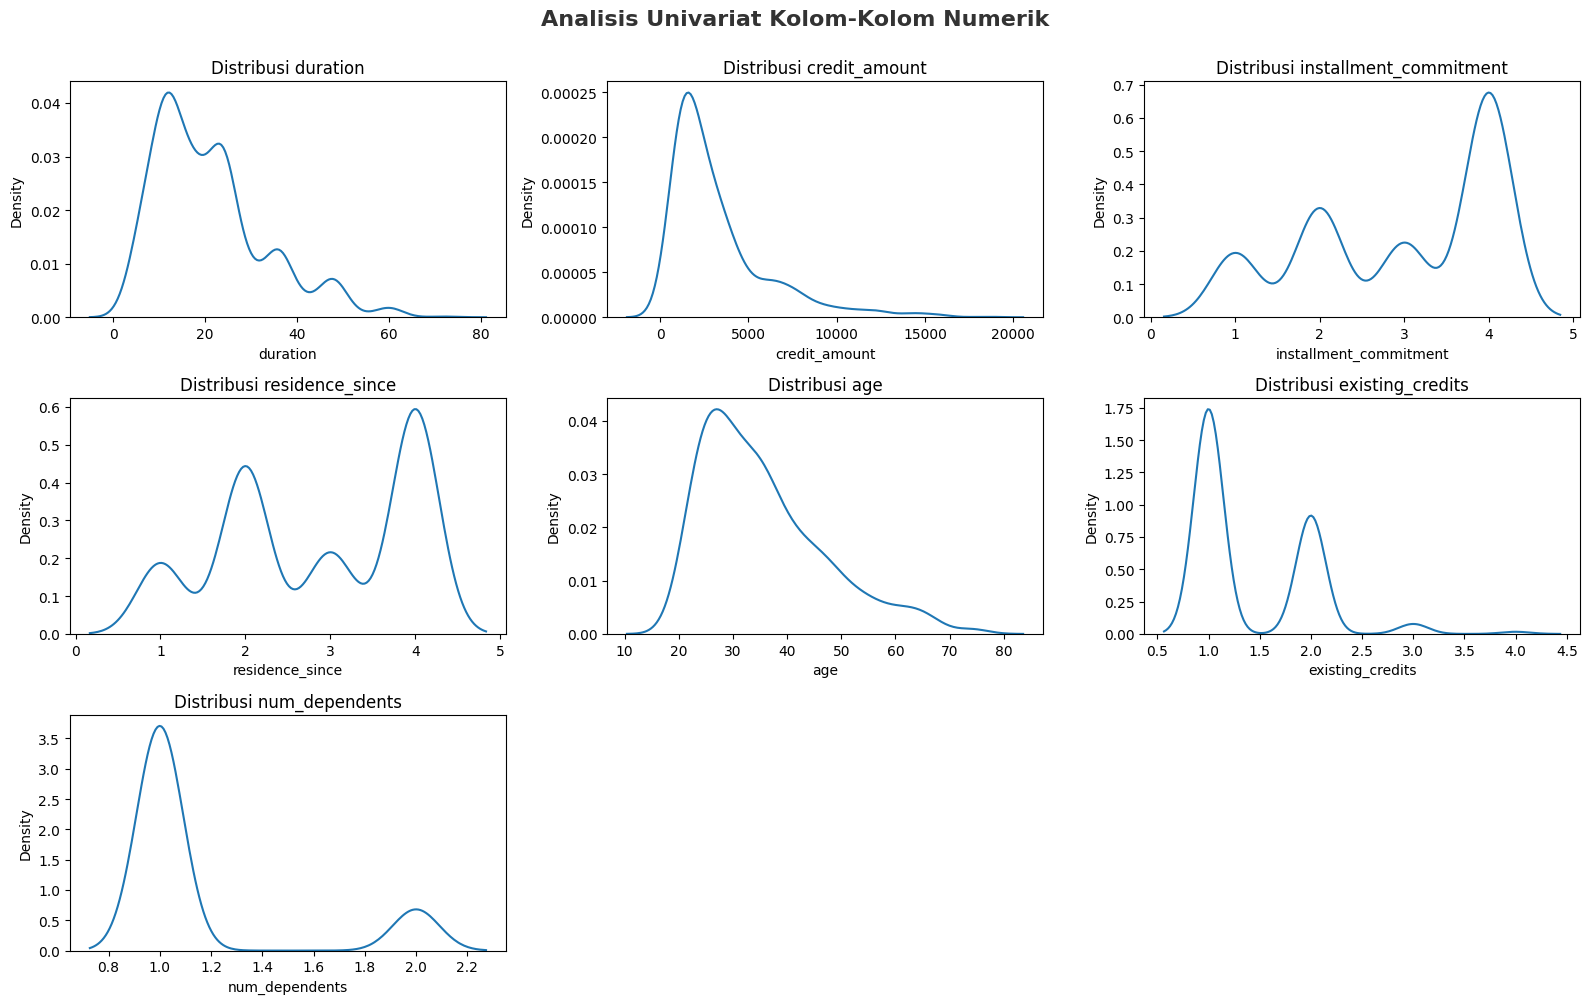

In [302]:
def KDEPlot_Numerical(df, height=10):
    # Memfilter DataFrame untuk hanya mengandung kolom-kolom numerik
    numerical_columns = df.select_dtypes(include=['number'])
    
    # Menentukan jumlah baris dan kolom untuk subplot secara dinamis
    num_numerical_cols = len(numerical_columns.columns)
    num_subplot_cols = 3  # Number of columns for subplots
    
    num_subplot_rows = (num_numerical_cols + num_subplot_cols - 1) // num_subplot_cols 
    
    # Membuat subplot
    plt.figure(figsize=(16, height))
    plt.suptitle('Analisis Univariat Kolom-Kolom Numerik', fontsize=16, fontweight='bold', alpha=0.8, y=1.)
    for i, column in enumerate(numerical_columns.columns):
        plt.subplot(num_subplot_rows, num_subplot_cols, i + 1)
        sns.kdeplot(data=numerical_columns[column])
        plt.title(f'Distribusi {column}')
    
    plt.tight_layout()
    plt.show()

df_copy = df.copy()
df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
KDEPlot_Numerical(df_copy, height=10)

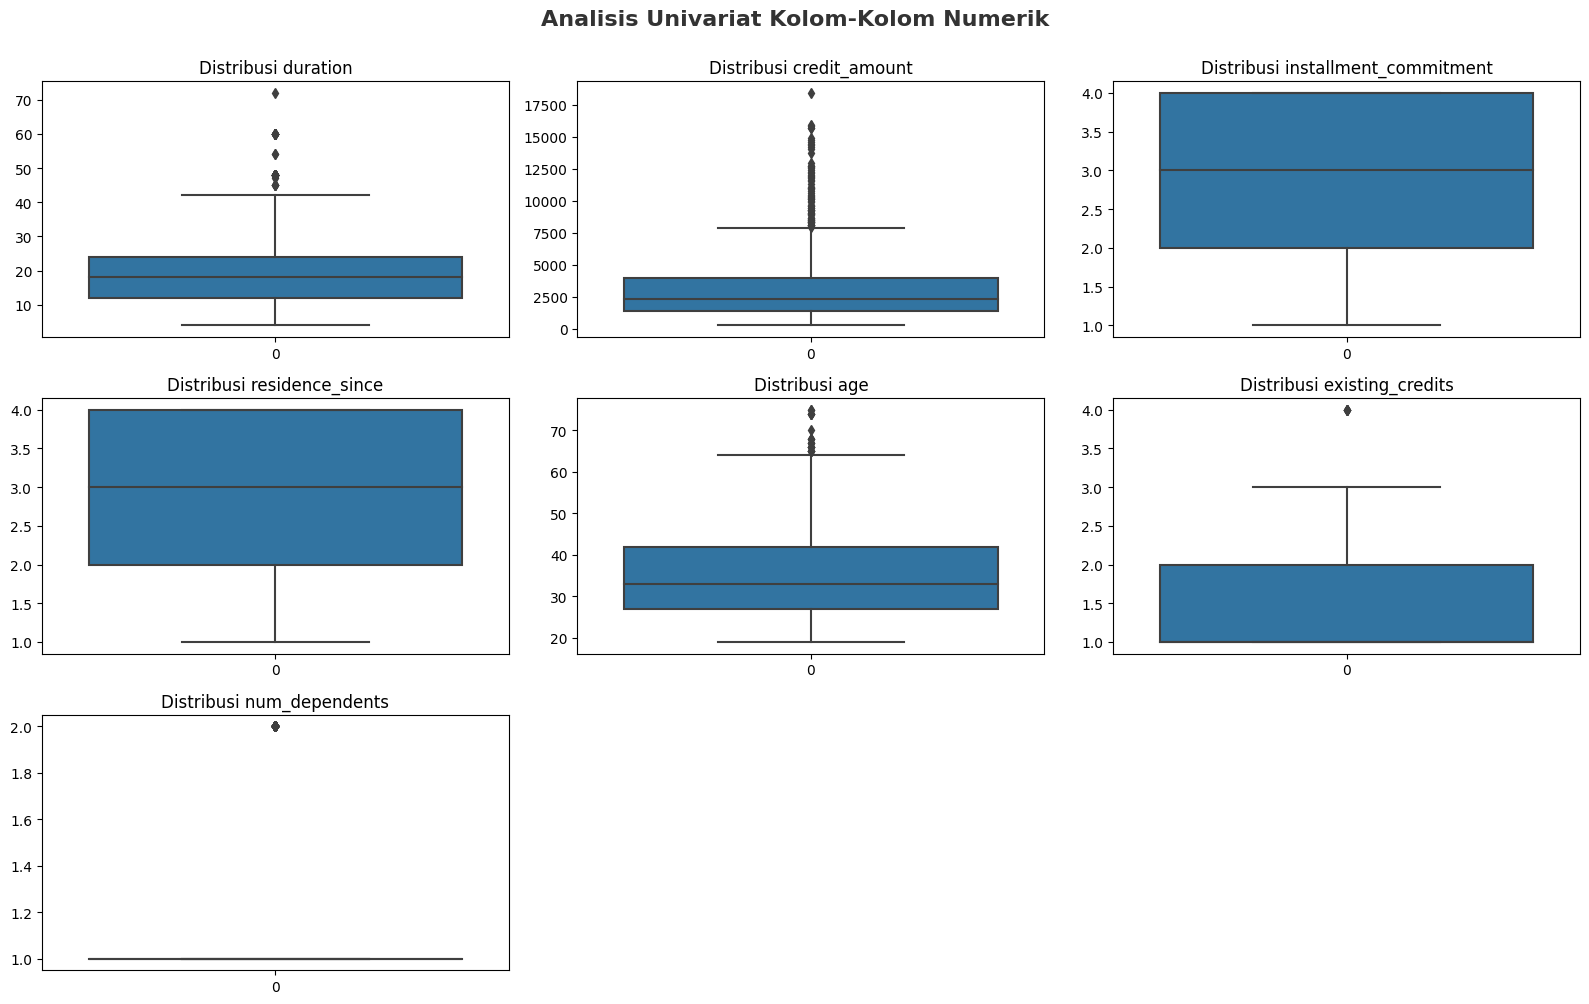

In [303]:
def boxplot_numerical(df, height=10):
    # Memfilter DataFrame untuk hanya mengandung kolom-kolom numerik
    numerical_columns = df.select_dtypes(include=['number'])
    
    # Menentukan jumlah baris dan kolom untuk subplot secara dinamis
    num_numerical_cols = len(numerical_columns.columns)
    num_subplot_cols = 3  # Number of columns for subplots
    
    num_subplot_rows = (num_numerical_cols + num_subplot_cols - 1) // num_subplot_cols 
    
    # Membuat subplot
    plt.figure(figsize=(16, height))
    plt.suptitle('Analisis Univariat Kolom-Kolom Numerik', fontsize=16, fontweight='bold', alpha=0.8, y=1.)
    for i, column in enumerate(numerical_columns.columns):
        plt.subplot(num_subplot_rows, num_subplot_cols, i + 1)
        sns.boxplot(data=numerical_columns[column])
        plt.title(f'Distribusi {column}')
    
    plt.tight_layout()
    plt.show()

boxplot_numerical(df, height=10)

Dari Visualisasi diatas didapat:
1. Hampir seluruh variabel menunjukkan distribusi non-normal
2. Beberapa variabel memiliki karakteristik *right-skewed* (credit_amount, duration)
3. Beberapa variabel terlihat seperti sebuah data kategorikal walaupun jenis datanya numerikal (residence_since, num_dependents)
4. credit_amount dan duration memiliki outlier

### Categorical Columns

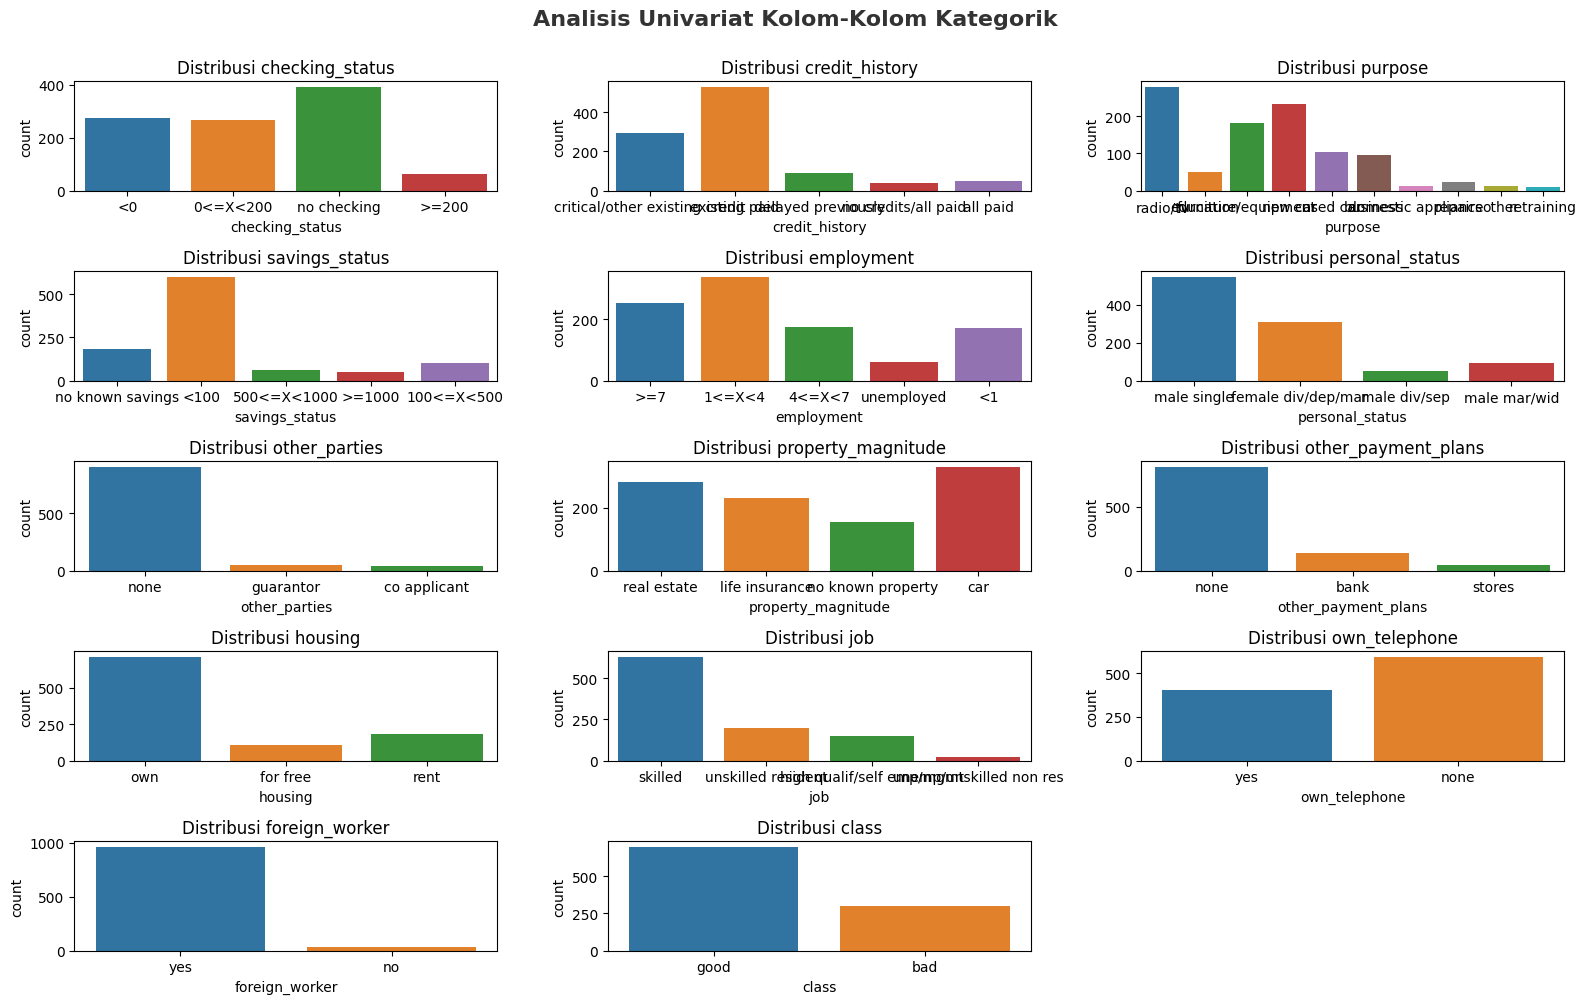

In [304]:
def countplot_categorical(df, height=10):
    # Memfilter DataFrame untuk hanya mengandung kolom-kolom kategorik
    categorical_columns = df.select_dtypes(include=['object'])
    
    # Menentukan jumlah baris dan kolom untuk subplot secara dinamis
    num_categorical_cols = len(categorical_columns.columns)
    num_subplot_cols = 3  # Number of columns for subplots
    
    num_subplot_rows = (num_categorical_cols + num_subplot_cols - 1) // num_subplot_cols 
    
    # Membuat subplot
    plt.figure(figsize=(16, height))
    plt.suptitle('Analisis Univariat Kolom-Kolom Kategorik', fontsize=16, fontweight='bold', alpha=0.8, y=1.)
    for i, column in enumerate(categorical_columns.columns):
        plt.subplot(num_subplot_rows, num_subplot_cols, i + 1)
        sns.countplot(data=categorical_columns, x=column)
        plt.title(f'Distribusi {column}')
    
    plt.tight_layout()
    plt.show()

countplot_categorical(df, height=10)

## Bivariate Analysis

### KDE plot on class 

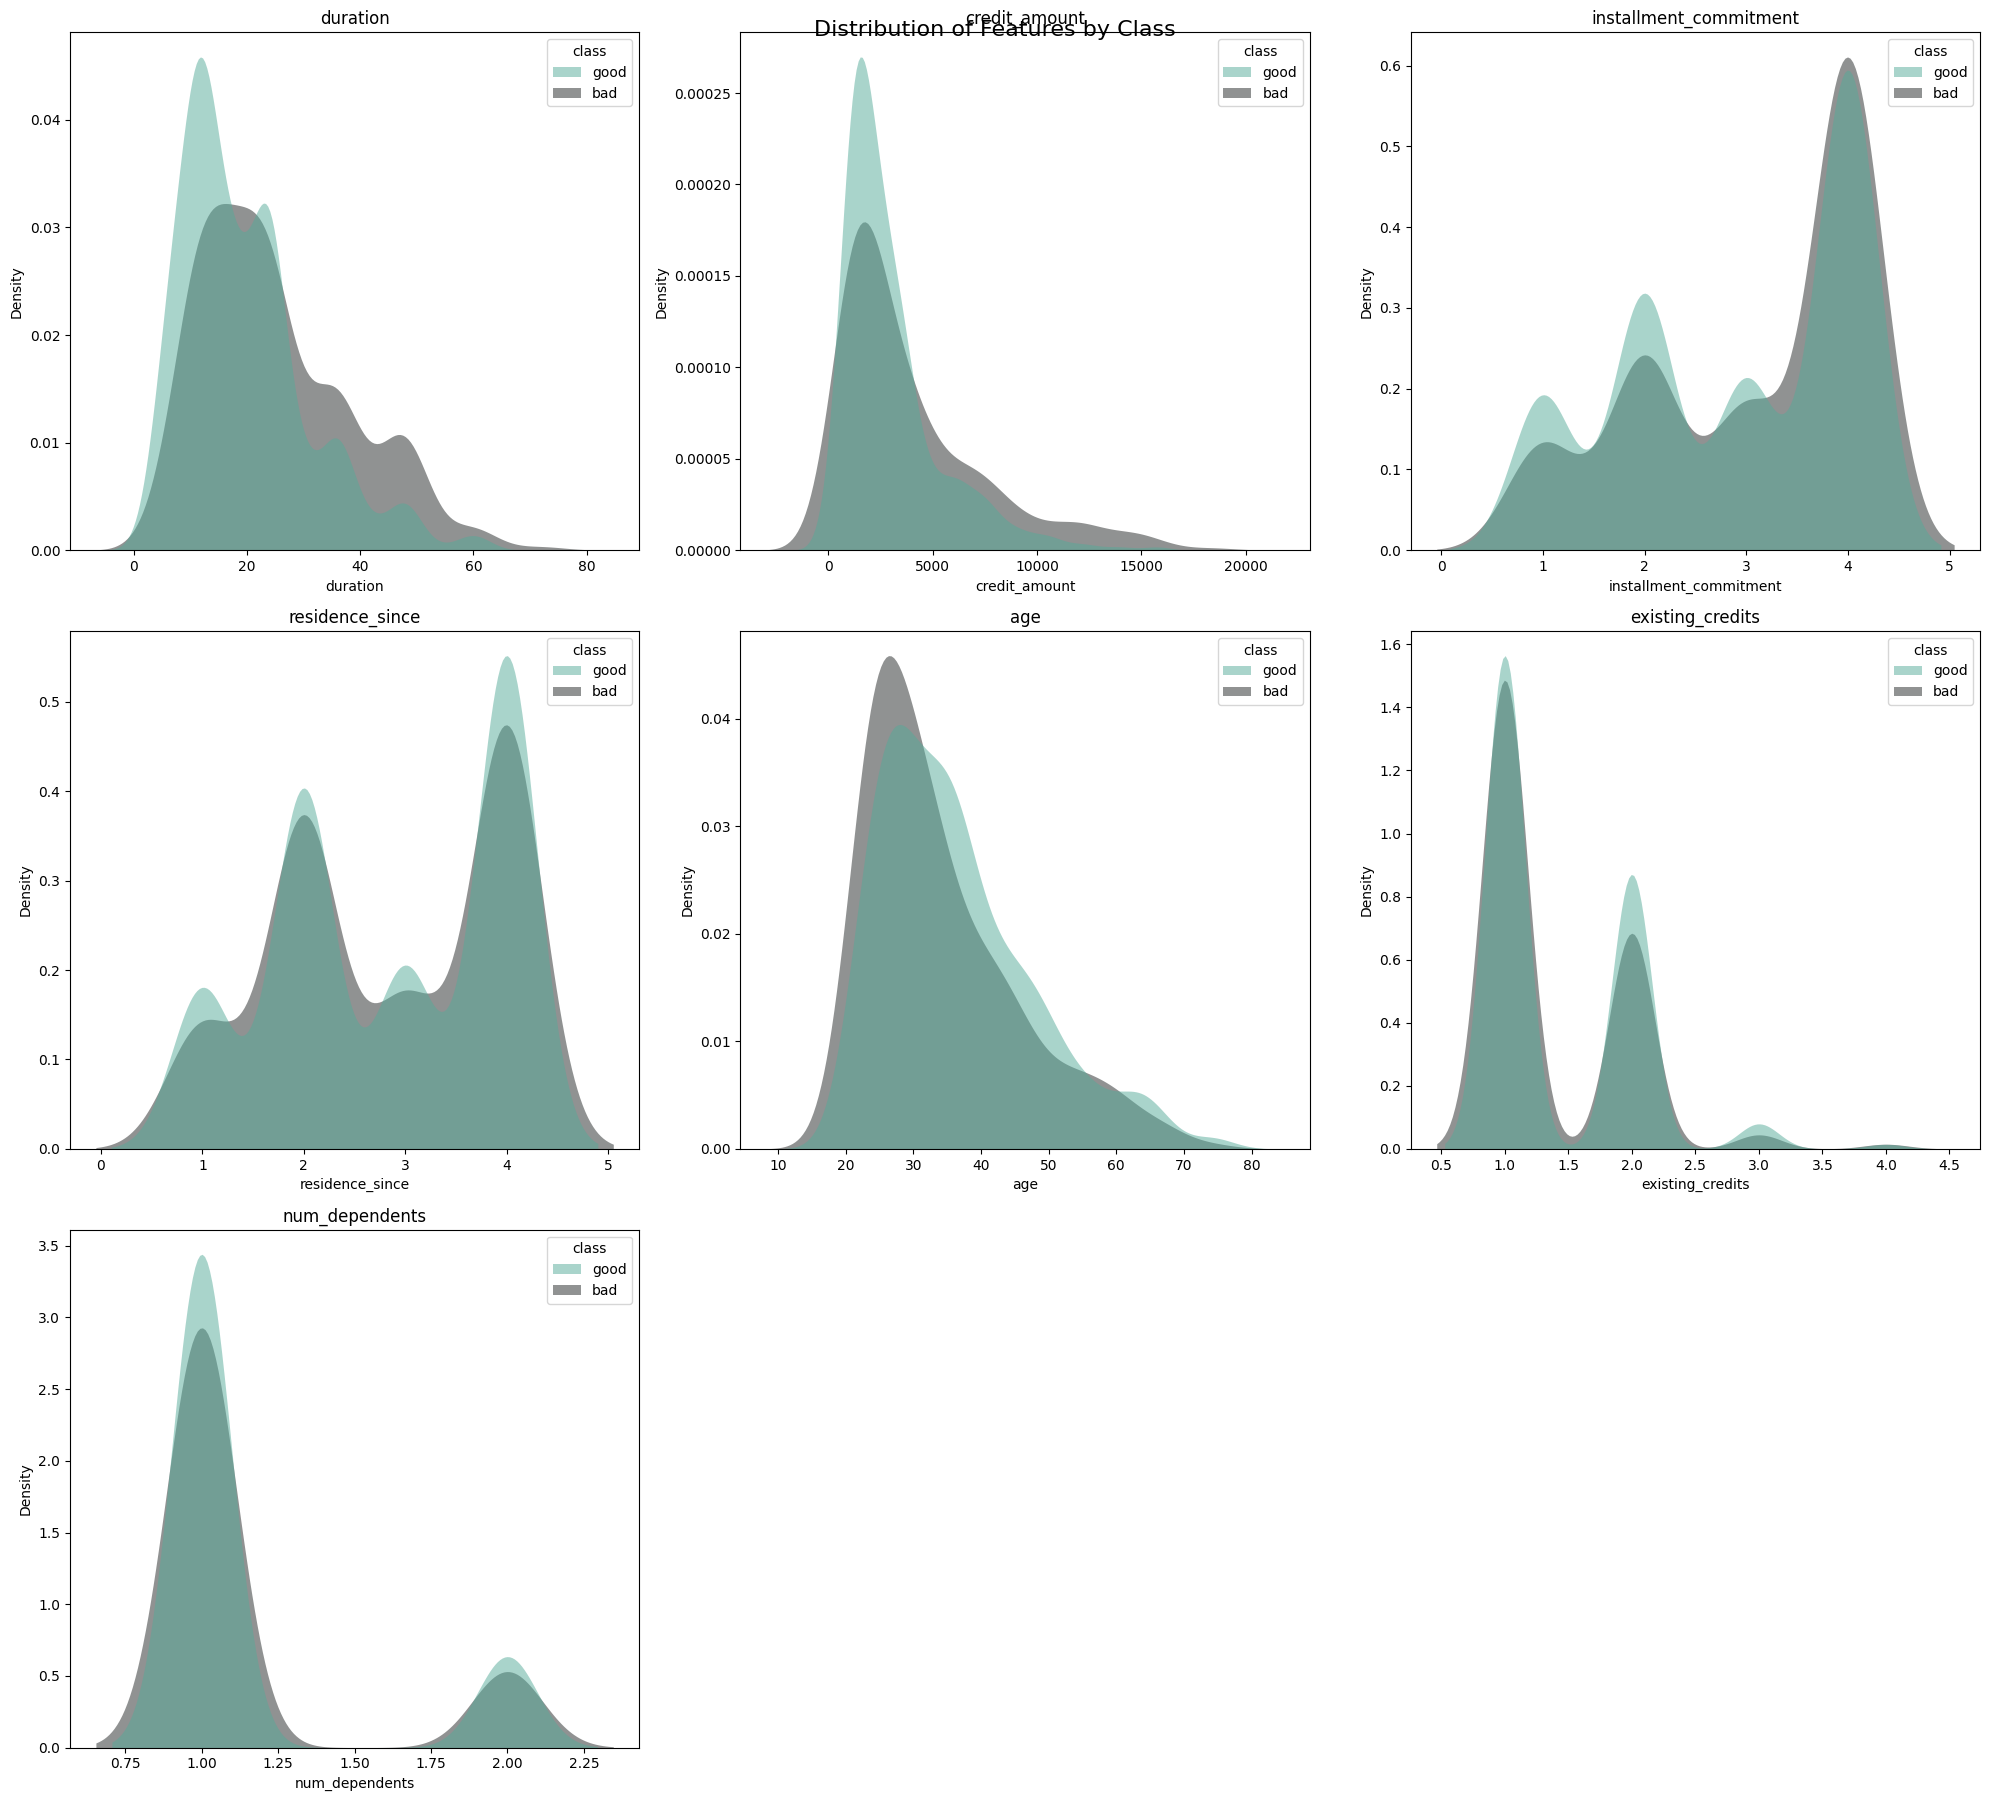

In [305]:
warnings.filterwarnings("ignore", category=FutureWarning)

numerical_columns = df.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(5, 3, figsize=(20, 30))
fig.suptitle('Distribution of Features by Class', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.kdeplot(data=df, x=column, hue="class", ax=axes[i],
                palette="dark:#5A9_r", fill=True, common_norm=False, 
                alpha=0.5, linewidth=0)
    axes[i].set_title(column)

for j in range(i+1, 15):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Cross Tab 

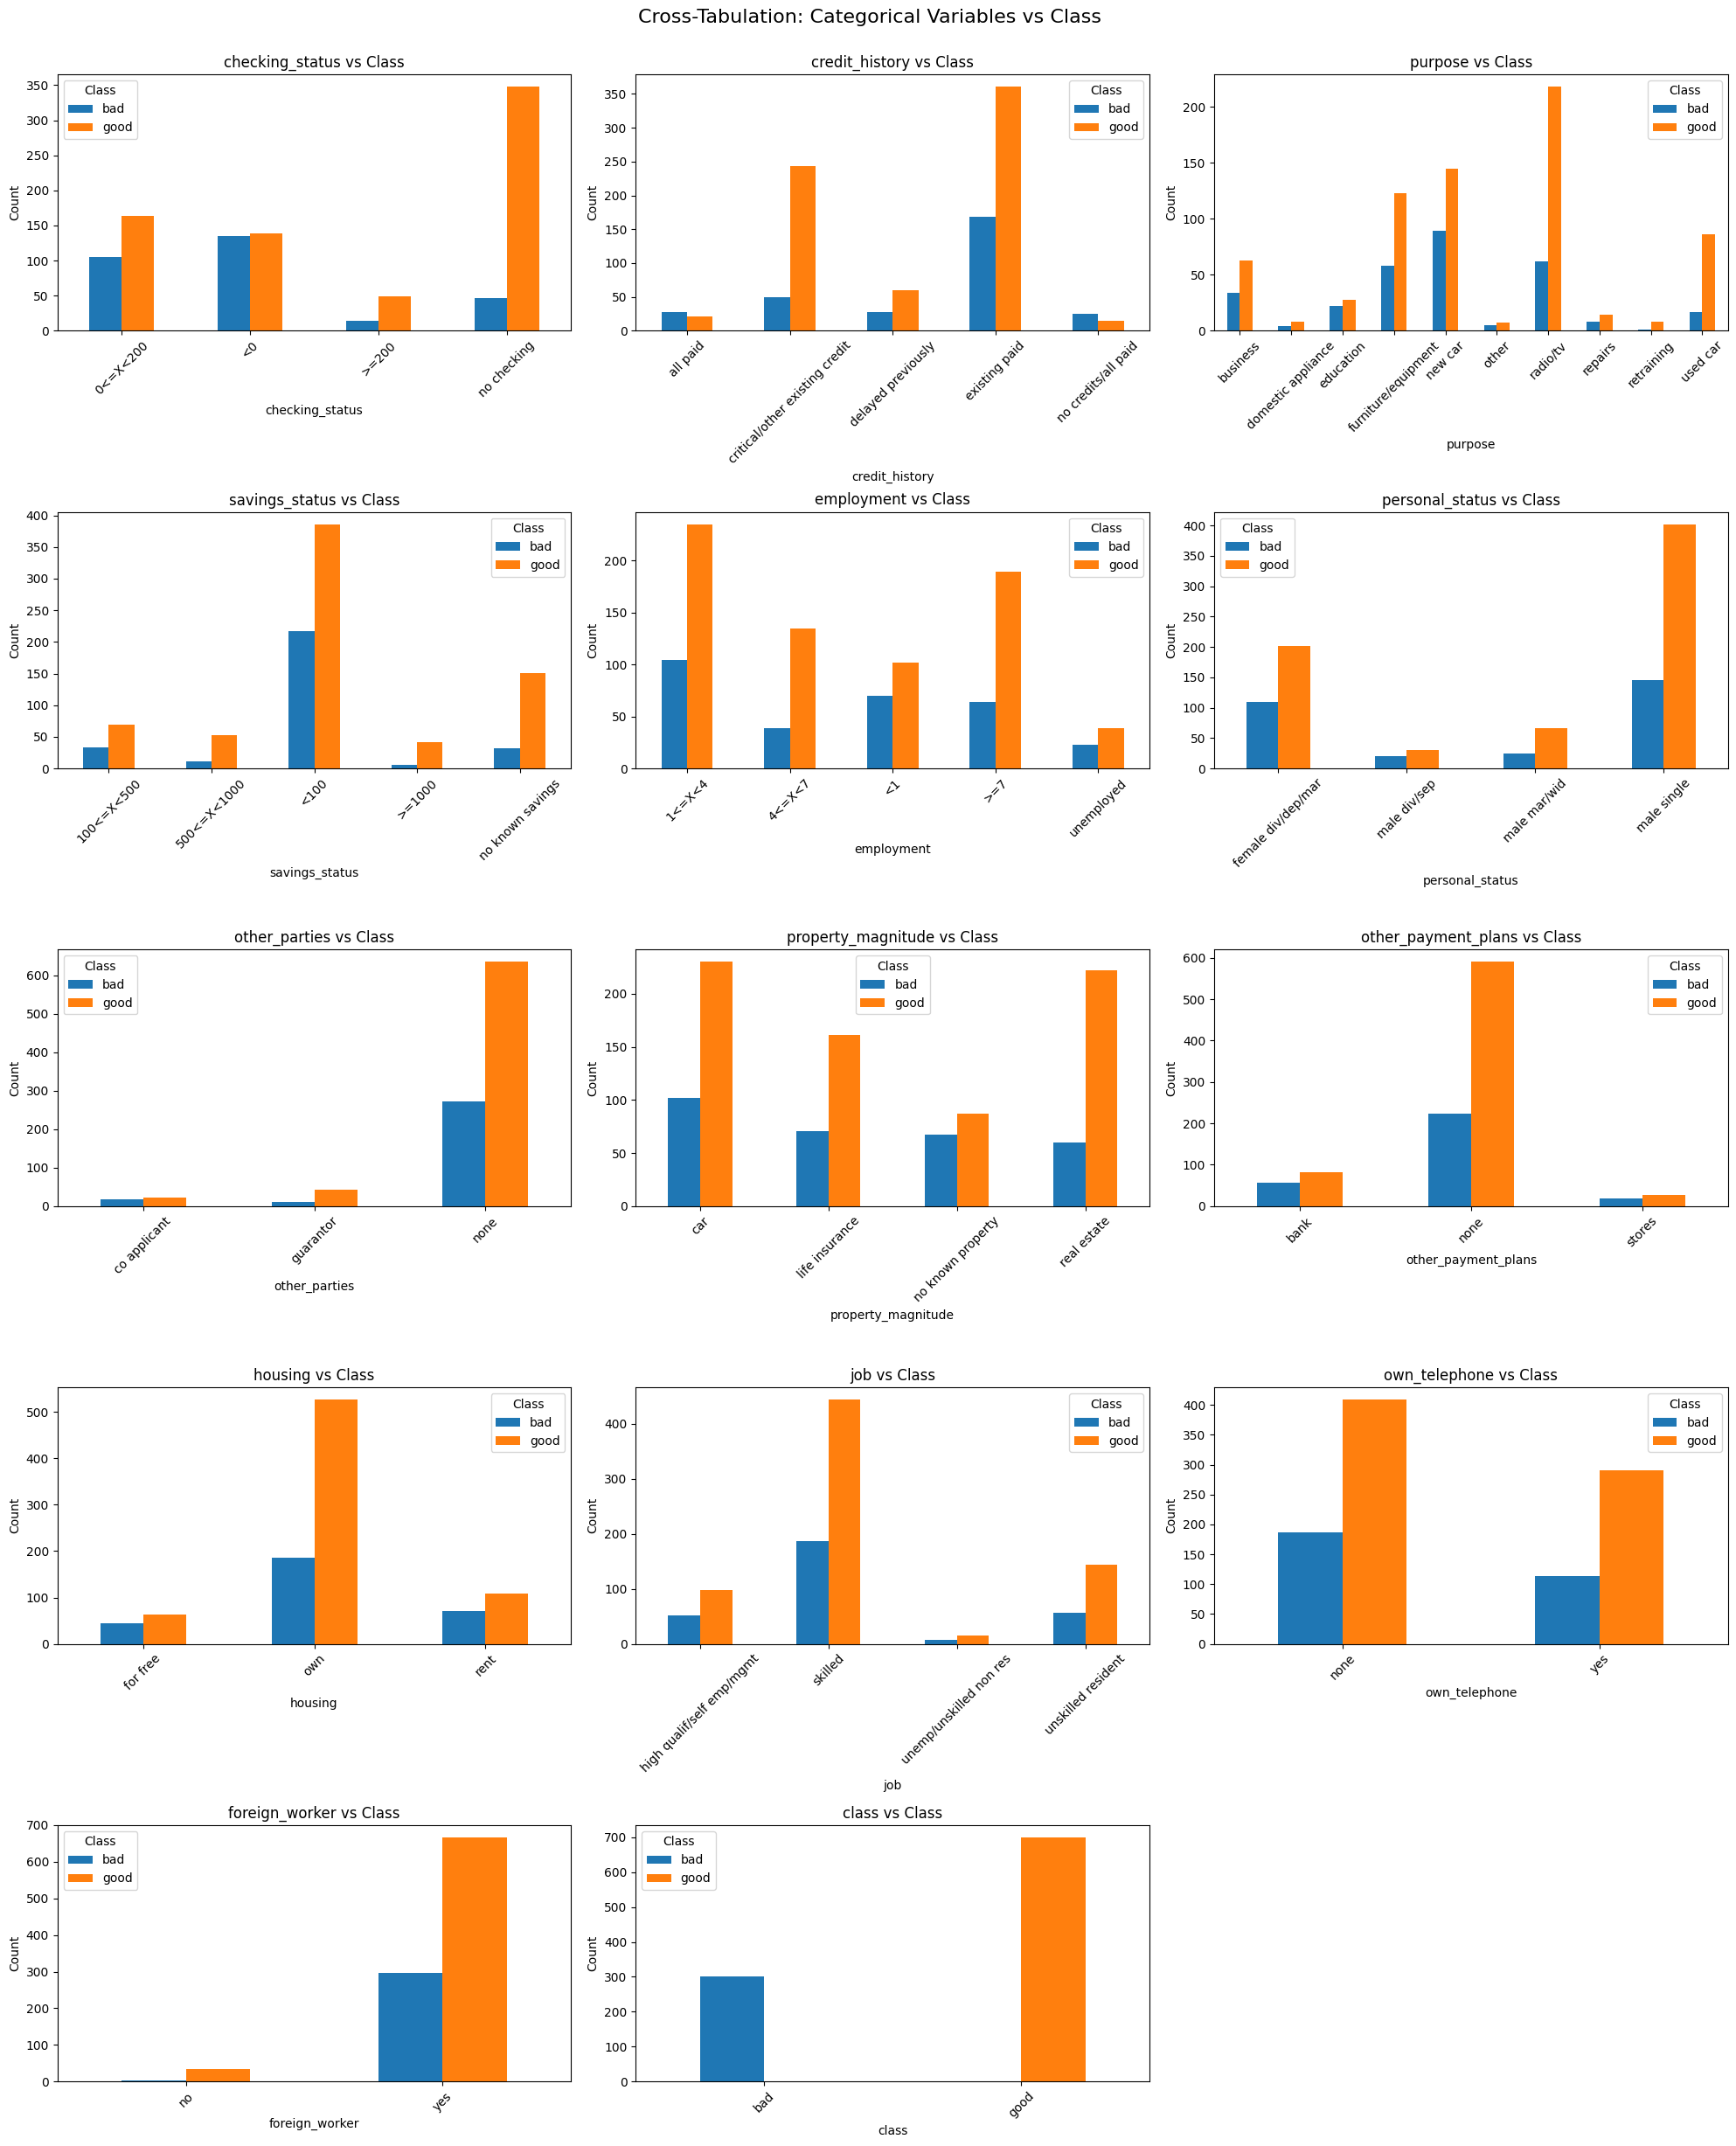

In [306]:
def cross_tab_categorical(df, height=5):
    # Get the categorical columns
    categorical_columns = df.select_dtypes(include=['object'])
    
    # Calculate the number of rows needed
    num_plots = len(categorical_columns.columns)
    num_rows = math.ceil(num_plots / 3)
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, height * num_rows))
    fig.suptitle('Cross-Tabulation: Categorical Variables vs Class', fontsize=16)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, column in enumerate(categorical_columns.columns):
        cross_tab = pd.crosstab(df[column], df['class'])
        cross_tab.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'{column} vs Class')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Class')
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for the main title
    plt.show()

# Call the function
cross_tab_categorical(df)

Insight:
1. Relasi antara atribut dengan class kebanyakan tidak linear 
2. Banyak atribut yang menunjukkan perbedaan antara resiko kredit baik dan kredit buruk
3. Indikator stabilitas keuangan (savings, checking status, property ownership) sangat terkait dengan risiko kredit.
4. Faktor pekerjaan (skill level) memainkan peran penting dalam penilaian kredit.
5. Tujuan pinjaman (purpose) tertentu memiliki risiko yang lebih tinggi daripada yang lain.
6. Karakteristik pribadi (status perkawinan, situasi perumahan) menunjukkan beberapa korelasi dengan risiko kredit.

* Disclaimer: Data memiliki distribusi kelas kredit yang imbalanced sehingga akan memengaruhi dalam analisisnya

### Correlation Matrix

In [307]:
corr_df = df.copy()
categorical_columns = corr_df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for column in categorical_columns:
    corr_df[column] = label_encoder.fit_transform(corr_df[column])

corr_df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,6.0,1,6,1169.0,4,3,4.0,3,2,...,3,67.0,1,1,2.0,1,1.0,1,1,1
1,0,48.0,3,6,5951.0,2,0,2.0,0,2,...,3,22.0,1,1,1.0,1,1.0,0,1,0
2,3,12.0,1,2,2096.0,2,1,2.0,3,2,...,3,49.0,1,1,1.0,3,2.0,0,1,1
3,1,42.0,3,3,7882.0,2,1,2.0,3,1,...,1,45.0,1,0,1.0,1,2.0,0,1,1
4,1,24.0,2,4,4870.0,2,0,3.0,3,2,...,2,53.0,1,0,2.0,1,2.0,0,1,0


Pearson Correlation Matrix:


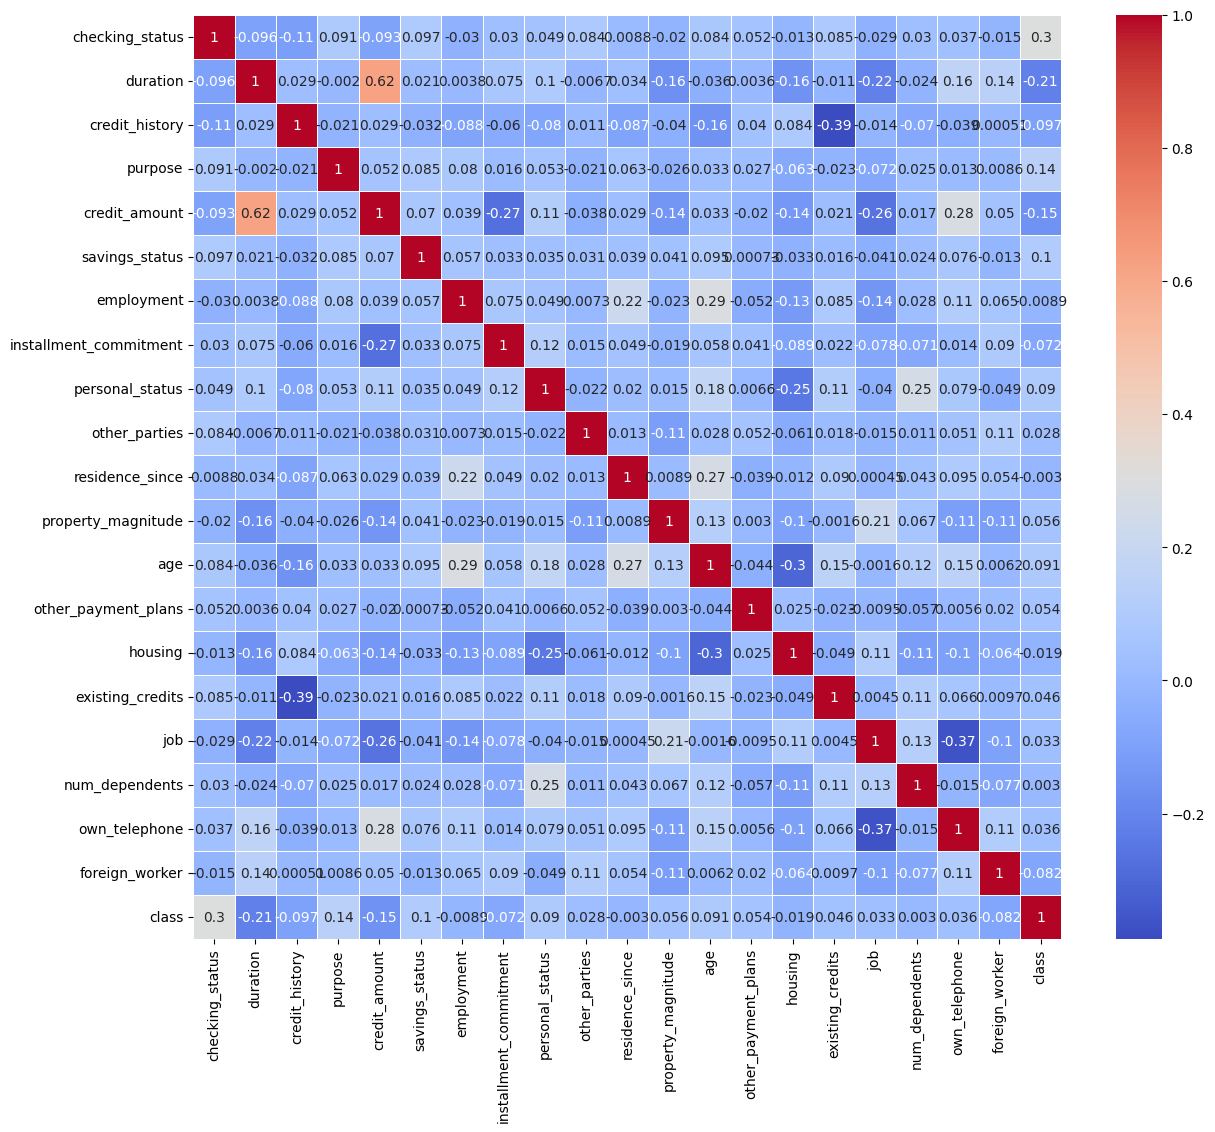

In [308]:
# Pearson correlation matrix analysis
correlation_matrix = corr_df.corr()

# Display the correlation matrix
print("Pearson Correlation Matrix:")

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

1. Satu-satunya korelasi yang kuat adalah antara atribut credit_amount dengan duration (0.62)

## Feature Importance

Hanya sebagai referensi

In [309]:
X_train = corr_df.drop('class', axis=1)
y_train = corr_df['class']

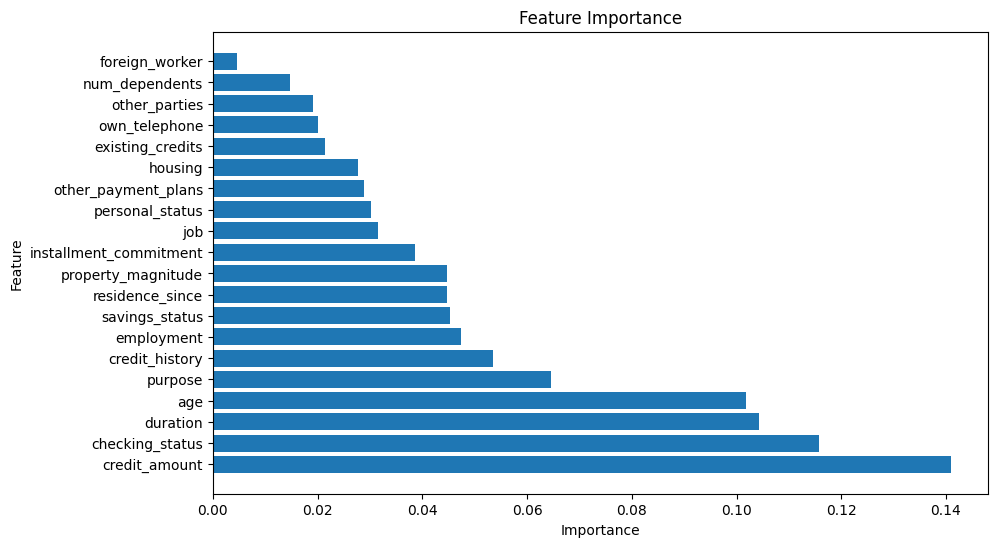

In [310]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_importances = model.feature_importances_

importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6) ,)
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Data Preprocessing

Tahap ini dilakukan untuk menyiapkan data supaya bisa digunakan oleh model pembelajaran nantinya pada tahap modelling

## Encoding

Encoding data kategorikal menjadi numerikal

In [311]:
def _encode(train_data, encoding_strategy="label", columns=None):

    if columns is None:
        columns = train_data.select_dtypes(include=['object']).columns
        columns = [col for col in columns if col != 'class']
    
    new_train = train_data.copy()
    
    if encoding_strategy == "onehot":
        new_train = pd.get_dummies(new_train, columns=columns)

    
    elif encoding_strategy == "label":
        label_encoders = {}
        for col in columns:
            # Combine training and validation data for consistent encoding
            
            # Fit the encoder on the combined data
            label_encoders[col] = LabelEncoder()
            label_encoders[col].fit(new_train[col])
            # Transform both training and validation data
            new_train[col] = label_encoders[col].transform(new_train[col])
    
    else:
        raise ValueError("Unsupported encoding strategy. Use 'onehot' or 'label'.")
    
    assert len(train_data) == len(new_train)
    
    return new_train

df = _encode(df)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,6.0,1,6,1169.0,4,3,4.0,3,2,...,3,67.0,1,1,2.0,1,1.0,1,1,good
1,0,48.0,3,6,5951.0,2,0,2.0,0,2,...,3,22.0,1,1,1.0,1,1.0,0,1,bad
2,3,12.0,1,2,2096.0,2,1,2.0,3,2,...,3,49.0,1,1,1.0,3,2.0,0,1,good
3,1,42.0,3,3,7882.0,2,1,2.0,3,1,...,1,45.0,1,0,1.0,1,2.0,0,1,good
4,1,24.0,2,4,4870.0,2,0,3.0,3,2,...,2,53.0,1,0,2.0,1,2.0,0,1,bad


## Outlier Handling

Mengatasi outlier pada kolom credit_amount

In [312]:
def handle_outliers_column(df, column, method='iqr', threshold=1.5):
    def iqr_method(x):
        q1, q3 = np.percentile(x, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return np.clip(x, lower_bound, upper_bound)
    
    def zscore_method(x):
        z = np.abs((x - np.mean(x)) / np.std(x))
        return x.where(z < threshold)
    
    if method == 'iqr':
        df[column] = iqr_method(df[column])
    elif method == 'zscore':
        df[column] = zscore_method(df[column])
    else:
        raise ValueError("Method must be 'iqr' or 'zscore'")
    
    return df

In [313]:
# df = handle_outliers_column(df,'credit_amount', 'iqr')
# df.describe()

## Standardization

Melakukan standarisasi data

In [314]:
def _scale(df):
    scaler = PowerTransformer()
    numerical_columns = df.select_dtypes(include=['number']).columns
    scaled_train = scaler.fit_transform(df[numerical_columns])
    
    #back to dataframe
    new_train = df.copy()
    
    new_train[numerical_columns] = scaled_train
    
    assert len(df) == len(new_train)
    
    return new_train

df = _scale(df)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,-0.344262,-1.797419,-1.172933,0.636928,-0.932701,1.647411,1.065782,0.959166,0.840080,0.320212,...,1.223648,1.966313,0.163602,-0.129767,1.275452,-0.120041,-0.428290,1.214598,0.196014,good
1,-1.346677,1.764587,0.725400,0.636928,1.156805,-0.117520,-1.234023,-0.963083,-1.376251,0.320212,...,1.223648,-1.607482,0.163602,-0.129767,-0.759740,-0.120041,-0.428290,-0.823318,0.196014,bad
2,1.089798,-0.694530,-1.172933,-1.016616,-0.157831,-0.117520,-0.195871,-0.963083,0.840080,0.320212,...,1.223648,1.211497,0.163602,-0.129767,-0.759740,1.594414,2.334869,-0.823318,0.196014,good
3,-0.344262,1.516606,0.725400,-0.587893,1.496009,-0.117520,-0.195871,-0.963083,0.840080,-3.119464,...,-0.127921,0.977107,0.163602,-2.029924,-0.759740,-0.120041,2.334869,-0.823318,0.196014,good
4,-0.344262,0.500910,-0.307192,-0.170997,0.911056,-0.117520,-1.234023,-0.109461,0.840080,0.320212,...,0.630937,1.415985,0.163602,-2.029924,1.275452,-0.120041,2.334869,-0.823318,0.196014,bad


# Train Test Split

In [315]:
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imbalanaced data handling

Memakai teknik SMOTE untuk mengatasi imbalanced data pada class 

In [316]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Modelling

In [317]:
models = {
    'KNN': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Catboost': CatBoostClassifier(),
    }

## Hyperparameter Tuning

Hyperparameter tuning dengan menggunakan RandomizedSearch 

*Dikarenakan pemakaiannya yang lama dan hasil yang diberikan juga kurang signifikan, bagian ini dilewati. Mungkin dapat dikembangkan dengan cara lain dalam hyperparameter tuningnya

In [318]:
def tune_models(X, y, models, n_iter=100, cv=5):
    tuned_models = {}
    param_distributions = {
        'KNN': {
            'n_neighbors': randint(1, 20),
            'weights': ['uniform', 'distance']
        },
        'GaussianNB': {
            'var_smoothing': uniform(1e-10, 1e-8)
        },
        'Decision Tree': {
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20)
        },
        'Random Forest': {
            'n_estimators': randint(100, 500),
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20)
        },
        'Support Vector Machine': {
            'C': uniform(0.1, 10),
            'kernel': ['rbf', 'linear'],
            'gamma': uniform(0.001, 0.1)
        },
        'Catboost': {
            'iterations': randint(100, 500),
            'depth': randint(4, 10),
            'learning_rate': uniform(0.01, 0.3)
        }
    }
    
    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Custom scoring function
    def custom_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, pos_label=1, average='binary')

    for name, model in models.items():
        print(f"Tuning {name}...")
        try:
            random_search = RandomizedSearchCV(
                model, 
                param_distributions[name], 
                n_iter=n_iter,
                cv=cv, 
                scoring=make_scorer(custom_f1_score),
                n_jobs=-1,
                random_state=42,
                error_score='raise'
            )
            random_search.fit(X, y_encoded)
            tuned_models[name] = random_search.best_estimator_
            print(f"Best parameters for {name}: {random_search.best_params_}")
            print(f"Best F1 score: {random_search.best_score_:.4f}\n")
        except Exception as e:
            print(f"Error tuning {name}: {str(e)}\n")

    return tuned_models

In [319]:
# tuned_models = tune_models(X_train, y_train, models)

## Evaluation Matrix

In [320]:
# Train and evaluate each model
evaluaton_results = []
evaluaton_results_recall = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the target values for the testing set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report['bad']['recall']
    
    classification_report_result = classification_report(y_test, y_pred)
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    
    evaluaton_results.append( (name, accuracy))
    evaluaton_results_recall.append( (name, recall))
    
    # Print the evaluation metrics for each model
    print(f"{name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report_result}")
    print(f"Confusion Matrix:\n{confusion_matrix_result}")
    print("----------------------------------")

KNN Evaluation Metrics:
Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

         bad       0.45      0.75      0.56        59
        good       0.85      0.62      0.72       141

    accuracy                           0.66       200
   macro avg       0.65      0.68      0.64       200
weighted avg       0.74      0.66      0.67       200

Confusion Matrix:
[[44 15]
 [53 88]]
----------------------------------
GaussianNB Evaluation Metrics:
Accuracy: 0.635
Classification Report:
              precision    recall  f1-score   support

         bad       0.43      0.71      0.54        59
        good       0.83      0.60      0.70       141

    accuracy                           0.64       200
   macro avg       0.63      0.66      0.62       200
weighted avg       0.71      0.64      0.65       200

Confusion Matrix:
[[42 17]
 [56 85]]
----------------------------------
Decision Tree Evaluation Metrics:
Accuracy: 0.72
Classification Report

In [321]:
print("Model Evaluation Results:")
for results in evaluaton_results:
    print(f"{results[0]} Accuracy = {results[1]}")

Model Evaluation Results:
KNN Accuracy = 0.66
GaussianNB Accuracy = 0.635
Decision Tree Accuracy = 0.72
Random Forest Accuracy = 0.765
Support Vector Machine Accuracy = 0.7
Catboost Accuracy = 0.795


In [322]:
print("Model Evaluation Results(Recall):")
for results in evaluaton_results_recall:
    print(f"{results[0]} Recall = {results[1]}")

Model Evaluation Results(Recall):
KNN Recall = 0.7457627118644068
GaussianNB Recall = 0.711864406779661
Decision Tree Recall = 0.6101694915254238
Random Forest Recall = 0.5423728813559322
Support Vector Machine Recall = 0.6440677966101694
Catboost Recall = 0.5932203389830508


# Conclusion

Setelah melakukan beberapa percobaan berikut hasil dari model prediksi:

### Accuracy
| N0 | Model                   | Plain | With Outlier Handling | With SMOTE |
|--------|-------------------------|-------|-----------------------|------------|
| 1      | KNN                     | 0.705 | 0.705                 | 0.66       |
| 2      | GaussianNB              | 0.72  | 0.72                  | 0.635      |
| 3      | Decision Tree           | 0.685 | 0.69                  | 0.725      |
| 4      | Random Forest           | 0.765 | 0.785                  | 0.765       |
| 5      | Support Vector Machine  | 0.765 | 0.775                 | 0.7        |
| 6      | Catboost                | 0.805 | 0.79                  | 0.795      |

### Recall (Bad Credit)
| No | Model                   | Plain | With Outlier Handling | With SMOTE |
|--------|-------------------------|-------|-----------------------|------------|
| 1      | KNN                     | 0.389 | 0.389                 | 0.745       |
| 2      | GaussianNB              | 0.66  | 0.661                  | 0.711      |
| 3      | Decision Tree           | 0.45 | 0.457                  | 0.61      |
| 4      | Random Forest           | 0.372 | 0.440                  | 0.542       |
| 5      | Support Vector Machine  | 0.355 | 0.389                 | 0.644        |
| 6      | Catboost                | 0.508 | 0.474                  | 0.593      |


Apabila dilihat data diatas, Model dengan akurasi terbaik adalah **Catboost** tetapi ia memiliki recall pada bad credit yang rendah. Maka, salah satu model yang paling baik digunakan adalah Model **GaussianNB** yang memiliki akurasi yang cukup baik (diatas 0.7) dan recall yang baik pula.

---

Beberapa saran untuk melanjutkan percobaan model prediksi diatas adalah:
1. Melakukan cara-cara lain dalam mengatasi imbalance data (Undersampling, dstnya)
2. Menggunakan Hyperparameter tuning dengan cara gridsearch
3. Mencari metode untuk melakukan feature engineering sehingga fitur-fiturnya dapat direduksi dan optimal dalam memakai fiturnya